# GANgster
In this notebook we will try to generate mugshots with our generator

In [1]:
import os
import glob
import json

import torch
from torch import nn
from IPython import display

import PIL
import time

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [2]:
image_size = 64
generator_entry = 50

device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("running on GPU")
else:
    device = torch.device("cpu")
    print("running on CPU")

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)), transforms.Resize((image_size, image_size)), transforms.Grayscale()]
)

running on GPU


In [3]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images_folder, transform=None):
        self.df = []
        for index, filepath in enumerate(glob.glob(f"{images_folder}/*")):
            if index % 15 == 0:
                filename = os.path.split(filepath)[1]
                image = PIL.Image.open(f"{images_folder}/{filename}")
                if transform is not None:
                    image = transform(image)
                self.df.append((image, filename))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        return self.df[index]


train_set = CustomDataset(
    images_folder="../data/front/front", transform=transform
)

In [4]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

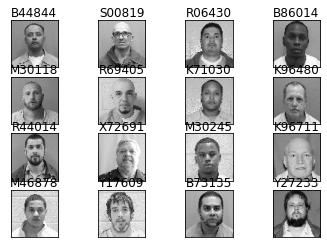

In [5]:
real_samples, real_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    ax.imshow(real_samples[i].reshape(image_size, image_size), cmap="gray")
    ax.set_title(real_labels[i], fontsize=12, pad=1.0)
    ax.set_xticks([])
    ax.set_yticks([])

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size ** 2, 2048),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), image_size ** 2)
        output = self.model(x)
        return output

In [7]:
discriminator = Discriminator().to(device=device)

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(generator_entry, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, 4096),
            nn.ReLU(),
            nn.Linear(4096, image_size ** 2),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, image_size, image_size)
        return output

In [9]:
generator = Generator().to(device=device)

In [10]:
lr = 0.00001
num_epochs = 20000
show_every = 10
loss_function = nn.BCELoss()

print("DATASET SIZE :", len(train_set))

DATASET SIZE : 4668


In [11]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [12]:
per_x_time = []
losses = {
    "generator": [],
    "discriminator": []
}

show_test_sample = torch.randn(1, generator_entry).to(device=device)

In [13]:
evolution = []

In [14]:
epoch_start = time.time()
for epoch in range(num_epochs):
    loss_discriminator = 0
    loss_generator = 0
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        
        real_samples = real_samples.to(device=device)
        real_samples_size = real_samples.shape[0]

        # Set the labels of the real data to one (Using the size of the real samples array)
        real_samples_labels = torch.ones((real_samples_size, 1)).to(device=device)

        # Set the labels of the fake data to zero
        latent_space_samples = torch.randn((real_samples_size, generator_entry)).to(device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((real_samples_size, 1)).to(device=device)

        # Concatenate true and fake data
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))
        
        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)

        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((real_samples_size, generator_entry)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

    # Show loss
    if epoch % show_every == 0 and epoch != 0:
        per_x_time.append(time.time() - epoch_start)
        epoch_start = time.time()
        losses["generator"].append(float(loss_generator))
        losses["discriminator"].append(float(loss_discriminator))

        ld = str(round(float(loss_discriminator), 10)).zfill(12)
        lg = str(round(float(loss_generator), 10)).zfill(12)
        it = str(round(per_x_time[-1], 4)).zfill(9)
        av = str(round(sum(per_x_time)/len(per_x_time), 2)).zfill(6)
        seconds = round(
            ((sum(per_x_time)/len(per_x_time)) * ((num_epochs - epoch)/show_every)),
            2
        )
        m, s = divmod(seconds, 60)
        h, m = divmod(m, 60)
        tl = "%d:%02d:%02d" % (h, m, s)
        print(f"[+] EPOCH : {str(epoch).zfill(7)} | LD.: {ld} | LG.: {lg} | IT : {it}s | AV : {av} | TL : {tl}""")
        
        generated_sample = generator(show_test_sample)
        generated_sample = generated_sample.cpu().detach()
        image = transforms.ToPILImage()(generated_sample[0].reshape(image_size, image_size))
        evolution.append(image)

[+] EPOCH : 0000010 | LD.: 0.2035770863 | LG.: 1.4251576662 | IT : 0031.7561s | AV : 031.76 | TL : 17:38:00
[+] EPOCH : 0000020 | LD.: 0.1909396946 | LG.: 2.8121349812 | IT : 0028.2753s | AV : 030.02 | TL : 16:39:31
[+] EPOCH : 0000030 | LD.: 0.1740354896 | LG.: 3.2730660439 | IT : 0028.3045s | AV : 029.45 | TL : 16:20:02
[+] EPOCH : 0000040 | LD.: 0.4571429491 | LG.: 2.7502117157 | IT : 0028.2754s | AV : 029.15 | TL : 16:09:49
[+] EPOCH : 0000050 | LD.: 0.1101699024 | LG.: 02.199508667 | IT : 0028.2924s | AV : 028.98 | TL : 16:03:36
[+] EPOCH : 0000060 | LD.: 0.0307673793 | LG.: 4.2511577606 | IT : 0028.2872s | AV : 028.87 | TL : 15:59:17
[+] EPOCH : 0000070 | LD.: 0.2750532627 | LG.: 2.4296178818 | IT : 00028.323s | AV : 028.79 | TL : 15:56:13
[+] EPOCH : 0000080 | LD.: 0.2547419667 | LG.: 2.6861481667 | IT : 0028.2531s | AV : 028.72 | TL : 15:53:32
[+] EPOCH : 0000090 | LD.: 0.0639012456 | LG.: 02.679649353 | IT : 0028.2681s | AV : 028.67 | TL : 15:51:23
[+] EPOCH : 0000100 | LD.: 0

[+] EPOCH : 0000770 | LD.: 0.6534597278 | LG.: 1.3846991062 | IT : 0027.7498s | AV : 027.95 | TL : 14:55:50
[+] EPOCH : 0000780 | LD.: 0.2709150314 | LG.: 2.5335979462 | IT : 0027.7548s | AV : 027.95 | TL : 14:55:17
[+] EPOCH : 0000790 | LD.: 0.3392710686 | LG.: 02.303832531 | IT : 0027.7576s | AV : 027.95 | TL : 14:54:44
[+] EPOCH : 0000800 | LD.: 0.3902530968 | LG.: 1.0367935896 | IT : 0027.7934s | AV : 027.94 | TL : 14:54:13
[+] EPOCH : 0000810 | LD.: 1.0448832512 | LG.: 0.5305865407 | IT : 0027.7573s | AV : 027.94 | TL : 14:53:40
[+] EPOCH : 0000820 | LD.: 00.838542223 | LG.: 0.6955028772 | IT : 0027.7621s | AV : 027.94 | TL : 14:53:08
[+] EPOCH : 0000830 | LD.: 0.4715277553 | LG.: 1.5357615948 | IT : 0027.7676s | AV : 027.94 | TL : 14:52:36
[+] EPOCH : 0000840 | LD.: 0.5364016294 | LG.: 0.8698604107 | IT : 0027.7872s | AV : 027.94 | TL : 14:52:05
[+] EPOCH : 0000850 | LD.: 0.4298055768 | LG.: 1.1381043196 | IT : 0027.7678s | AV : 027.93 | TL : 14:51:33
[+] EPOCH : 0000860 | LD.: 0

[+] EPOCH : 0001530 | LD.: 0.5433592796 | LG.: 1.7570847273 | IT : 0027.7963s | AV : 027.86 | TL : 14:17:46
[+] EPOCH : 0001540 | LD.: 0.3594764173 | LG.: 3.0315637589 | IT : 0027.7784s | AV : 027.86 | TL : 14:17:17
[+] EPOCH : 0001550 | LD.: 0.2834573388 | LG.: 2.4984097481 | IT : 0027.7785s | AV : 027.86 | TL : 14:16:48
[+] EPOCH : 0001560 | LD.: 0.3492141664 | LG.: 1.9872409105 | IT : 0027.8042s | AV : 027.86 | TL : 14:16:19
[+] EPOCH : 0001570 | LD.: 0.4898924232 | LG.: 1.8008211851 | IT : 0027.7864s | AV : 027.86 | TL : 14:15:51
[+] EPOCH : 0001580 | LD.: 0.3182589412 | LG.: 1.8324038982 | IT : 0027.8058s | AV : 027.86 | TL : 14:15:22
[+] EPOCH : 0001590 | LD.: 0.4459767342 | LG.: 1.9793208838 | IT : 0027.7947s | AV : 027.86 | TL : 14:14:53
[+] EPOCH : 0001600 | LD.: 0.4396672845 | LG.: 2.0753848553 | IT : 0027.7901s | AV : 027.86 | TL : 14:14:25
[+] EPOCH : 0001610 | LD.: 0.3763501942 | LG.: 1.7040150166 | IT : 0027.7853s | AV : 027.86 | TL : 14:13:56
[+] EPOCH : 0001620 | LD.: 0

[+] EPOCH : 0002290 | LD.: 0.3241252899 | LG.: 2.8586339951 | IT : 0027.8324s | AV : 027.84 | TL : 13:41:52
[+] EPOCH : 0002300 | LD.: 0.2455885261 | LG.: 2.3879892826 | IT : 0027.8345s | AV : 027.84 | TL : 13:41:24
[+] EPOCH : 0002310 | LD.: 0.2796086371 | LG.: 2.6147639751 | IT : 00027.866s | AV : 027.84 | TL : 13:40:56
[+] EPOCH : 0002320 | LD.: 0.2183087319 | LG.: 02.592466116 | IT : 0027.8446s | AV : 027.84 | TL : 13:40:28
[+] EPOCH : 0002330 | LD.: 0.1898144186 | LG.: 2.7877254486 | IT : 0027.8384s | AV : 027.84 | TL : 13:40:00
[+] EPOCH : 0002340 | LD.: 0.2057208121 | LG.: 2.7991995811 | IT : 0027.8316s | AV : 027.84 | TL : 13:39:32
[+] EPOCH : 0002350 | LD.: 0.2850033641 | LG.: 2.9576094151 | IT : 0027.8681s | AV : 027.84 | TL : 13:39:05
[+] EPOCH : 0002360 | LD.: 0.2482178807 | LG.: 2.8834457397 | IT : 0027.8536s | AV : 027.84 | TL : 13:38:37
[+] EPOCH : 0002370 | LD.: 0.3026502728 | LG.: 2.7991352081 | IT : 0027.8234s | AV : 027.84 | TL : 13:38:09
[+] EPOCH : 0002380 | LD.: 0

[+] EPOCH : 0003050 | LD.: 0.0163563844 | LG.: 5.5233240128 | IT : 0027.8369s | AV : 027.84 | TL : 13:06:33
[+] EPOCH : 0003060 | LD.: 0.1056957394 | LG.: 06.658364296 | IT : 0027.8277s | AV : 027.84 | TL : 13:06:05
[+] EPOCH : 0003070 | LD.: 0.0445414819 | LG.: 05.398601532 | IT : 0027.8188s | AV : 027.84 | TL : 13:05:37
[+] EPOCH : 0003080 | LD.: 0.0224642921 | LG.: 6.5817570686 | IT : 0027.8384s | AV : 027.84 | TL : 13:05:09
[+] EPOCH : 0003090 | LD.: 0.0116956085 | LG.: 6.9886713028 | IT : 0027.8404s | AV : 027.84 | TL : 13:04:41
[+] EPOCH : 0003100 | LD.: 0.0550676957 | LG.: 5.5369210243 | IT : 0027.8344s | AV : 027.84 | TL : 13:04:14
[+] EPOCH : 0003110 | LD.: 0.0434367582 | LG.: 5.2648210526 | IT : 0027.8342s | AV : 027.84 | TL : 13:03:46
[+] EPOCH : 0003120 | LD.: 0.0136588523 | LG.: 6.4247603416 | IT : 0027.8074s | AV : 027.84 | TL : 13:03:18
[+] EPOCH : 0003130 | LD.: 0.1131658927 | LG.: 05.704808712 | IT : 0027.7773s | AV : 027.84 | TL : 13:02:49
[+] EPOCH : 0003140 | LD.: 0

[+] EPOCH : 0003810 | LD.: 0.0241506752 | LG.: 5.3719587326 | IT : 0027.8392s | AV : 027.84 | TL : 12:31:14
[+] EPOCH : 0003820 | LD.: 0.0191961098 | LG.: 5.6911358833 | IT : 0027.8591s | AV : 027.84 | TL : 12:30:46
[+] EPOCH : 0003830 | LD.: 0.0061662528 | LG.: 5.9944167137 | IT : 0027.8999s | AV : 027.84 | TL : 12:30:18
[+] EPOCH : 0003840 | LD.: 0.0110069579 | LG.: 6.6976699829 | IT : 0027.7805s | AV : 027.84 | TL : 12:29:50
[+] EPOCH : 0003850 | LD.: 0.0110018635 | LG.: 5.8659553528 | IT : 0027.8282s | AV : 027.84 | TL : 12:29:22
[+] EPOCH : 0003860 | LD.: 0.0154237943 | LG.: 0005.1185112 | IT : 0027.8394s | AV : 027.84 | TL : 12:28:54
[+] EPOCH : 0003870 | LD.: 0.0027778542 | LG.: 6.1096906662 | IT : 0027.8261s | AV : 027.84 | TL : 12:28:26
[+] EPOCH : 0003880 | LD.: 0.0081329709 | LG.: 6.3188643456 | IT : 0027.8383s | AV : 027.84 | TL : 12:27:59
[+] EPOCH : 0003890 | LD.: 0.0270940848 | LG.: 6.6195569038 | IT : 0027.8262s | AV : 027.84 | TL : 12:27:31
[+] EPOCH : 0003900 | LD.: 0

[+] EPOCH : 0004570 | LD.: 0.0916813239 | LG.: 5.2252840996 | IT : 0027.8254s | AV : 027.84 | TL : 11:55:57
[+] EPOCH : 0004580 | LD.: 0.0127760852 | LG.: 6.6897854805 | IT : 0027.8316s | AV : 027.84 | TL : 11:55:29
[+] EPOCH : 0004590 | LD.: 0.0332255438 | LG.: 5.1881117821 | IT : 0027.8341s | AV : 027.84 | TL : 11:55:01
[+] EPOCH : 0004600 | LD.: 0.0109590478 | LG.: 6.5528893471 | IT : 0027.8546s | AV : 027.84 | TL : 11:54:34
[+] EPOCH : 0004610 | LD.: 00.038912639 | LG.: 5.3563323021 | IT : 0027.8199s | AV : 027.84 | TL : 11:54:06
[+] EPOCH : 0004620 | LD.: 0.0477043353 | LG.: 5.2859711647 | IT : 0027.8397s | AV : 027.84 | TL : 11:53:38
[+] EPOCH : 0004630 | LD.: 0.0460586362 | LG.: 7.4506878853 | IT : 0027.8369s | AV : 027.84 | TL : 11:53:10
[+] EPOCH : 0004640 | LD.: 0.0138703212 | LG.: 5.1035914421 | IT : 0027.8711s | AV : 027.84 | TL : 11:52:42
[+] EPOCH : 0004650 | LD.: 0.0194285456 | LG.: 05.626200676 | IT : 0027.8265s | AV : 027.84 | TL : 11:52:14
[+] EPOCH : 0004660 | LD.: 0

[+] EPOCH : 0005330 | LD.: 0.0203432329 | LG.: 5.3159604073 | IT : 0027.8346s | AV : 027.84 | TL : 11:20:40
[+] EPOCH : 0005340 | LD.: 0.0133372433 | LG.: 6.1471247673 | IT : 0027.8094s | AV : 027.84 | TL : 11:20:12
[+] EPOCH : 0005350 | LD.: 0.0305387303 | LG.: 06.713435173 | IT : 0027.8142s | AV : 027.84 | TL : 11:19:44
[+] EPOCH : 0005360 | LD.: 0.0132670132 | LG.: 5.9349122047 | IT : 0027.8124s | AV : 027.84 | TL : 11:19:16
[+] EPOCH : 0005370 | LD.: 0.0993103907 | LG.: 5.7364282608 | IT : 0027.8352s | AV : 027.84 | TL : 11:18:49
[+] EPOCH : 0005380 | LD.: 0.1121382341 | LG.: 5.7323961258 | IT : 0027.8079s | AV : 027.84 | TL : 11:18:21
[+] EPOCH : 0005390 | LD.: 00.023034716 | LG.: 6.1551876068 | IT : 0027.8155s | AV : 027.84 | TL : 11:17:53
[+] EPOCH : 0005400 | LD.: 0.0303718783 | LG.: 5.6509718895 | IT : 0027.8308s | AV : 027.84 | TL : 11:17:25
[+] EPOCH : 0005410 | LD.: 0.0566745698 | LG.: 5.4689412117 | IT : 0027.8207s | AV : 027.84 | TL : 11:16:57
[+] EPOCH : 0005420 | LD.: 0

[+] EPOCH : 0006090 | LD.: 0.0298530161 | LG.: 5.1724743843 | IT : 0027.8251s | AV : 027.84 | TL : 10:45:23
[+] EPOCH : 0006100 | LD.: 0.0518314205 | LG.: 5.2447900772 | IT : 0027.8332s | AV : 027.84 | TL : 10:44:55
[+] EPOCH : 0006110 | LD.: 0.0583763234 | LG.: 5.9737653732 | IT : 0027.8711s | AV : 027.84 | TL : 10:44:27
[+] EPOCH : 0006120 | LD.: 00.034003783 | LG.: 5.6194553375 | IT : 0027.8489s | AV : 027.84 | TL : 10:43:59
[+] EPOCH : 0006130 | LD.: 0.1325800717 | LG.: 5.3107495308 | IT : 0027.8397s | AV : 027.84 | TL : 10:43:31
[+] EPOCH : 0006140 | LD.: 0.0424925014 | LG.: 5.8765907288 | IT : 0027.8472s | AV : 027.84 | TL : 10:43:04
[+] EPOCH : 0006150 | LD.: 0.0494253188 | LG.: 5.7211794853 | IT : 0027.8499s | AV : 027.84 | TL : 10:42:36
[+] EPOCH : 0006160 | LD.: 0.0117178867 | LG.: 5.5465455055 | IT : 0027.8396s | AV : 027.84 | TL : 10:42:08
[+] EPOCH : 0006170 | LD.: 0.0184925124 | LG.: 5.2074341774 | IT : 0027.8415s | AV : 027.84 | TL : 10:41:40
[+] EPOCH : 0006180 | LD.: 0

[+] EPOCH : 0006850 | LD.: 00.142711699 | LG.: 5.6718945503 | IT : 0027.8344s | AV : 027.84 | TL : 10:10:07
[+] EPOCH : 0006860 | LD.: 0.0577817112 | LG.: 5.5410861969 | IT : 0027.8403s | AV : 027.84 | TL : 10:09:39
[+] EPOCH : 0006870 | LD.: 0.0203572437 | LG.: 5.5329427719 | IT : 0027.8411s | AV : 027.84 | TL : 10:09:12
[+] EPOCH : 0006880 | LD.: 0.0786153749 | LG.: 4.6146407127 | IT : 00027.857s | AV : 027.84 | TL : 10:08:44
[+] EPOCH : 0006890 | LD.: 0.0343842916 | LG.: 6.0057120323 | IT : 0027.8389s | AV : 027.84 | TL : 10:08:16
[+] EPOCH : 0006900 | LD.: 0.0966349468 | LG.: 4.7032809258 | IT : 0027.8318s | AV : 027.84 | TL : 10:07:48
[+] EPOCH : 0006910 | LD.: 0.0818126574 | LG.: 5.0127973557 | IT : 0027.8316s | AV : 027.84 | TL : 10:07:20
[+] EPOCH : 0006920 | LD.: 0.0603957511 | LG.: 5.2606878281 | IT : 0027.8477s | AV : 027.84 | TL : 10:06:52
[+] EPOCH : 0006930 | LD.: 0.0491596274 | LG.: 04.835422039 | IT : 0027.7515s | AV : 027.84 | TL : 10:06:24
[+] EPOCH : 0006940 | LD.: 0

[+] EPOCH : 0007620 | LD.: 0.1757122427 | LG.: 6.5246071815 | IT : 0027.8331s | AV : 027.84 | TL : 9:34:22
[+] EPOCH : 0007630 | LD.: 0.0159941763 | LG.: 5.8262758255 | IT : 0027.8436s | AV : 027.84 | TL : 9:33:54
[+] EPOCH : 0007640 | LD.: 0.1528406292 | LG.: 5.7774090767 | IT : 0027.8311s | AV : 027.84 | TL : 9:33:26
[+] EPOCH : 0007650 | LD.: 0.0112249535 | LG.: 5.8903226852 | IT : 0027.8224s | AV : 027.84 | TL : 9:32:58
[+] EPOCH : 0007660 | LD.: 0.0133572845 | LG.: 5.8673653603 | IT : 0027.8605s | AV : 027.84 | TL : 9:32:31
[+] EPOCH : 0007670 | LD.: 0.0284900237 | LG.: 5.9782013893 | IT : 0027.8337s | AV : 027.84 | TL : 9:32:03
[+] EPOCH : 0007680 | LD.: 0.1189320907 | LG.: 5.1362571716 | IT : 0027.8462s | AV : 027.84 | TL : 9:31:35
[+] EPOCH : 0007690 | LD.: 0.0405843146 | LG.: 5.5188570023 | IT : 0027.8415s | AV : 027.84 | TL : 9:31:07
[+] EPOCH : 0007700 | LD.: 0.0588349812 | LG.: 5.8210840225 | IT : 0027.8684s | AV : 027.84 | TL : 9:30:39
[+] EPOCH : 0007710 | LD.: 0.01208332

[+] EPOCH : 0008390 | LD.: 00.044997301 | LG.: 7.9596905708 | IT : 0027.8428s | AV : 027.84 | TL : 8:58:39
[+] EPOCH : 0008400 | LD.: 0.0366920568 | LG.: 7.0581455231 | IT : 0027.8414s | AV : 027.84 | TL : 8:58:11
[+] EPOCH : 0008410 | LD.: 0.0717210844 | LG.: 06.418961525 | IT : 0027.8349s | AV : 027.84 | TL : 8:57:43
[+] EPOCH : 0008420 | LD.: 0.0678341687 | LG.: 6.9380636215 | IT : 0027.8442s | AV : 027.84 | TL : 8:57:15
[+] EPOCH : 0008430 | LD.: 0.0022394878 | LG.: 6.5651869774 | IT : 0027.8611s | AV : 027.84 | TL : 8:56:47
[+] EPOCH : 0008440 | LD.: 0.0376704223 | LG.: 5.9519658089 | IT : 0027.8395s | AV : 027.84 | TL : 8:56:20
[+] EPOCH : 0008450 | LD.: 0.0192632359 | LG.: 6.4075708389 | IT : 0027.8224s | AV : 027.84 | TL : 8:55:52
[+] EPOCH : 0008460 | LD.: 0.0372828506 | LG.: 6.2607688904 | IT : 0027.8295s | AV : 027.84 | TL : 8:55:24
[+] EPOCH : 0008470 | LD.: 0.0118977623 | LG.: 5.6425890923 | IT : 0027.8426s | AV : 027.84 | TL : 8:54:56
[+] EPOCH : 0008480 | LD.: 0.01386144

[+] EPOCH : 0009160 | LD.: 0.0950605571 | LG.: 7.1494641304 | IT : 0027.8361s | AV : 027.84 | TL : 8:22:56
[+] EPOCH : 0009170 | LD.: 0.0151072852 | LG.: 7.4304475784 | IT : 0027.8529s | AV : 027.84 | TL : 8:22:28
[+] EPOCH : 0009180 | LD.: 0.0222502556 | LG.: 07.846780777 | IT : 0027.8385s | AV : 027.84 | TL : 8:22:00
[+] EPOCH : 0009190 | LD.: 0.0660322607 | LG.: 8.1715240479 | IT : 0027.8477s | AV : 027.84 | TL : 8:21:32
[+] EPOCH : 0009200 | LD.: 0.0683887526 | LG.: 7.3213334084 | IT : 0027.8279s | AV : 027.84 | TL : 8:21:04
[+] EPOCH : 0009210 | LD.: 0.0316469111 | LG.: 6.9256315231 | IT : 0027.8509s | AV : 027.84 | TL : 8:20:36
[+] EPOCH : 0009220 | LD.: 0.0111910738 | LG.: 8.0986394882 | IT : 00027.848s | AV : 027.84 | TL : 8:20:09
[+] EPOCH : 0009230 | LD.: 0.0051124715 | LG.: 6.2619681358 | IT : 0027.8226s | AV : 027.84 | TL : 8:19:41
[+] EPOCH : 0009240 | LD.: 0.0050215018 | LG.: 6.2096066475 | IT : 0027.8267s | AV : 027.84 | TL : 8:19:13
[+] EPOCH : 0009250 | LD.: 0.02562506

[+] EPOCH : 0009930 | LD.: 0.0038421394 | LG.: 6.6881809235 | IT : 00027.833s | AV : 027.84 | TL : 7:47:10
[+] EPOCH : 0009940 | LD.: 0.0654105395 | LG.: 7.0426812172 | IT : 0027.8498s | AV : 027.84 | TL : 7:46:43
[+] EPOCH : 0009950 | LD.: 0.0006680621 | LG.: 9.8408880234 | IT : 0027.8273s | AV : 027.84 | TL : 7:46:15
[+] EPOCH : 0009960 | LD.: 00.003560876 | LG.: 6.2899594307 | IT : 0027.8352s | AV : 027.84 | TL : 7:45:47
[+] EPOCH : 0009970 | LD.: 0.0378708169 | LG.: 05.933473587 | IT : 00027.838s | AV : 027.84 | TL : 7:45:19
[+] EPOCH : 0009980 | LD.: 0.0023866901 | LG.: 7.6416840553 | IT : 0027.8506s | AV : 027.84 | TL : 7:44:51
[+] EPOCH : 0009990 | LD.: 00.005208923 | LG.: 06.668255806 | IT : 0027.8564s | AV : 027.84 | TL : 7:44:23
[+] EPOCH : 0010000 | LD.: 0.0074880342 | LG.: 6.8879265785 | IT : 0027.8297s | AV : 027.84 | TL : 7:43:56
[+] EPOCH : 0010010 | LD.: 0.0176062062 | LG.: 6.9462180138 | IT : 0027.8424s | AV : 027.84 | TL : 7:43:28
[+] EPOCH : 0010020 | LD.: 0.00715134

[+] EPOCH : 0010700 | LD.: 0.0172230043 | LG.: 8.2364177704 | IT : 0027.8321s | AV : 027.84 | TL : 7:11:27
[+] EPOCH : 0010710 | LD.: 0.0145694558 | LG.: 7.3857374191 | IT : 0027.8396s | AV : 027.84 | TL : 7:10:59
[+] EPOCH : 0010720 | LD.: 0.0063317474 | LG.: 8.6515932083 | IT : 0027.8656s | AV : 027.84 | TL : 7:10:32
[+] EPOCH : 0010730 | LD.: 0.0171164665 | LG.: 07.011534214 | IT : 0027.8465s | AV : 027.84 | TL : 7:10:04
[+] EPOCH : 0010740 | LD.: 00.001840957 | LG.: 7.0561590195 | IT : 0027.8274s | AV : 027.84 | TL : 7:09:36
[+] EPOCH : 0010750 | LD.: 0.0034691007 | LG.: 7.0321364403 | IT : 0027.8405s | AV : 027.84 | TL : 7:09:08
[+] EPOCH : 0010760 | LD.: 0.0442222469 | LG.: 6.1474452019 | IT : 0027.8411s | AV : 027.84 | TL : 7:08:40
[+] EPOCH : 0010770 | LD.: 0.0013918946 | LG.: 8.2489728928 | IT : 0027.8319s | AV : 027.84 | TL : 7:08:12
[+] EPOCH : 0010780 | LD.: 0.0589642264 | LG.: 7.8291640282 | IT : 0027.8345s | AV : 027.84 | TL : 7:07:45
[+] EPOCH : 0010790 | LD.: 00.0018016

[+] EPOCH : 0011470 | LD.: 0.0566828847 | LG.: 6.7062177658 | IT : 0027.8202s | AV : 027.85 | TL : 6:35:52
[+] EPOCH : 0011480 | LD.: 0.0146346493 | LG.: 6.4170413017 | IT : 0027.8164s | AV : 027.85 | TL : 6:35:24
[+] EPOCH : 0011490 | LD.: 00.006604881 | LG.: 7.6000809669 | IT : 0027.8816s | AV : 027.85 | TL : 6:34:56
[+] EPOCH : 0011500 | LD.: 0.0035497728 | LG.: 7.0933432579 | IT : 0027.8766s | AV : 027.85 | TL : 6:34:29
[+] EPOCH : 0011510 | LD.: 000.00193595 | LG.: 7.4912266731 | IT : 0027.7581s | AV : 027.85 | TL : 6:34:01
[+] EPOCH : 0011520 | LD.: 0.0252729431 | LG.: 6.7667040825 | IT : 0027.7576s | AV : 027.85 | TL : 6:33:33
[+] EPOCH : 0011530 | LD.: 0.0156309474 | LG.: 7.6653933525 | IT : 0027.7738s | AV : 027.85 | TL : 6:33:05
[+] EPOCH : 0011540 | LD.: 0.0088075064 | LG.: 6.6513676643 | IT : 0027.7514s | AV : 027.85 | TL : 6:32:37
[+] EPOCH : 0011550 | LD.: 0.1177478507 | LG.: 8.2531890869 | IT : 0027.7694s | AV : 027.85 | TL : 6:32:09
[+] EPOCH : 0011560 | LD.: 0.01393506

[+] EPOCH : 0012240 | LD.: 0.0107257217 | LG.: 6.4786376953 | IT : 0027.7753s | AV : 027.84 | TL : 6:00:06
[+] EPOCH : 0012250 | LD.: 0.0098406291 | LG.: 7.4816045761 | IT : 00027.764s | AV : 027.84 | TL : 5:59:38
[+] EPOCH : 0012260 | LD.: 0.1595422626 | LG.: 7.7154278755 | IT : 0027.7905s | AV : 027.84 | TL : 5:59:10
[+] EPOCH : 0012270 | LD.: 0.0782558471 | LG.: 06.837826252 | IT : 00027.805s | AV : 027.84 | TL : 5:58:42
[+] EPOCH : 0012280 | LD.: 0.0249647144 | LG.: 8.5288677216 | IT : 0027.7801s | AV : 027.84 | TL : 5:58:14
[+] EPOCH : 0012290 | LD.: 0.0263938084 | LG.: 6.9931664467 | IT : 00027.794s | AV : 027.84 | TL : 5:57:47
[+] EPOCH : 0012300 | LD.: 0.0244020429 | LG.: 5.8947305679 | IT : 0027.8033s | AV : 027.84 | TL : 5:57:19
[+] EPOCH : 0012310 | LD.: 0.0126589593 | LG.: 7.1197152138 | IT : 0027.8182s | AV : 027.84 | TL : 5:56:51
[+] EPOCH : 0012320 | LD.: 0.0818853602 | LG.: 6.7776918411 | IT : 0027.7922s | AV : 027.84 | TL : 5:56:23
[+] EPOCH : 0012330 | LD.: 0.00293232

[+] EPOCH : 0013010 | LD.: 0.0149742495 | LG.: 7.4810180664 | IT : 0027.7928s | AV : 027.84 | TL : 5:24:20
[+] EPOCH : 0013020 | LD.: 00.009011724 | LG.: 5.9878473282 | IT : 0027.7938s | AV : 027.84 | TL : 5:23:52
[+] EPOCH : 0013030 | LD.: 0.0319018103 | LG.: 6.6157126427 | IT : 0027.7937s | AV : 027.84 | TL : 5:23:25
[+] EPOCH : 0013040 | LD.: 0.0025663369 | LG.: 6.8572664261 | IT : 00027.814s | AV : 027.84 | TL : 5:22:57
[+] EPOCH : 0013050 | LD.: 0.0206377283 | LG.: 9.3566675186 | IT : 00027.793s | AV : 027.84 | TL : 5:22:29
[+] EPOCH : 0013060 | LD.: 0.1320127547 | LG.: 6.5951786041 | IT : 0027.7962s | AV : 027.84 | TL : 5:22:01
[+] EPOCH : 0013070 | LD.: 0.0706794485 | LG.: 7.2554507256 | IT : 0027.7845s | AV : 027.84 | TL : 5:21:33
[+] EPOCH : 0013080 | LD.: 0.0666272342 | LG.: 7.5136651993 | IT : 0027.7932s | AV : 027.84 | TL : 5:21:05
[+] EPOCH : 0013090 | LD.: 0.0239763465 | LG.: 7.8971862793 | IT : 0027.8081s | AV : 027.84 | TL : 5:20:37
[+] EPOCH : 0013100 | LD.: 0.01620574

[+] EPOCH : 0013780 | LD.: 0.0087151723 | LG.: 6.5302634239 | IT : 0027.8465s | AV : 027.84 | TL : 4:48:36
[+] EPOCH : 0013790 | LD.: 0.0083029065 | LG.: 7.9456048012 | IT : 0027.8314s | AV : 027.84 | TL : 4:48:08
[+] EPOCH : 0013800 | LD.: 0.0319062583 | LG.: 7.3029184341 | IT : 0027.8254s | AV : 027.84 | TL : 4:47:40
[+] EPOCH : 0013810 | LD.: 00.025368385 | LG.: 7.9329843521 | IT : 0027.8214s | AV : 027.84 | TL : 4:47:12
[+] EPOCH : 0013820 | LD.: 0.0046923566 | LG.: 7.4927697182 | IT : 0027.8374s | AV : 027.84 | TL : 4:46:44
[+] EPOCH : 0013830 | LD.: 0.0048930021 | LG.: 8.8547811508 | IT : 00027.824s | AV : 027.84 | TL : 4:46:17
[+] EPOCH : 0013840 | LD.: 0.0080496762 | LG.: 6.0943183899 | IT : 0027.8297s | AV : 027.84 | TL : 4:45:49
[+] EPOCH : 0013850 | LD.: 0.0044149063 | LG.: 7.4449124336 | IT : 0027.8256s | AV : 027.84 | TL : 4:45:21
[+] EPOCH : 0013860 | LD.: 0.0444719903 | LG.: 6.8041772842 | IT : 0027.8535s | AV : 027.84 | TL : 4:44:53
[+] EPOCH : 0013870 | LD.: 0.01241033

[+] EPOCH : 0014550 | LD.: 0.0102048619 | LG.: 6.6445178986 | IT : 0027.7971s | AV : 027.84 | TL : 4:12:53
[+] EPOCH : 0014560 | LD.: 0.0211516339 | LG.: 06.353167057 | IT : 0027.7532s | AV : 027.84 | TL : 4:12:25
[+] EPOCH : 0014570 | LD.: 0.0423303582 | LG.: 7.4350266457 | IT : 0027.7573s | AV : 027.84 | TL : 4:11:57
[+] EPOCH : 0014580 | LD.: 00.005201397 | LG.: 8.1768760681 | IT : 0027.7571s | AV : 027.84 | TL : 4:11:30
[+] EPOCH : 0014590 | LD.: 0.0094563765 | LG.: 7.4348773956 | IT : 0027.8692s | AV : 027.84 | TL : 4:11:02
[+] EPOCH : 0014600 | LD.: 0.0017622643 | LG.: 7.2745671272 | IT : 0027.8632s | AV : 027.84 | TL : 4:10:34
[+] EPOCH : 0014610 | LD.: 0.0107483547 | LG.: 7.5541324615 | IT : 00027.827s | AV : 027.84 | TL : 4:10:06
[+] EPOCH : 0014620 | LD.: 0.0315502509 | LG.: 7.5254683495 | IT : 00027.829s | AV : 027.84 | TL : 4:09:38
[+] EPOCH : 0014630 | LD.: 00.015217036 | LG.: 7.8150477409 | IT : 0027.8245s | AV : 027.84 | TL : 4:09:10
[+] EPOCH : 0014640 | LD.: 0.00242240

[+] EPOCH : 0015320 | LD.: 0.0414614938 | LG.: 6.6435723305 | IT : 0027.8206s | AV : 027.84 | TL : 3:37:10
[+] EPOCH : 0015330 | LD.: 0.0090854624 | LG.: 7.1246638298 | IT : 0028.1591s | AV : 027.84 | TL : 3:36:42
[+] EPOCH : 0015340 | LD.: 0.0090264957 | LG.: 06.591366291 | IT : 00027.877s | AV : 027.84 | TL : 3:36:14
[+] EPOCH : 0015350 | LD.: 0.0034238196 | LG.: 7.2409358025 | IT : 0027.8721s | AV : 027.84 | TL : 3:35:47
[+] EPOCH : 0015360 | LD.: 00.023765754 | LG.: 7.5116019249 | IT : 00027.878s | AV : 027.84 | TL : 3:35:19
[+] EPOCH : 0015370 | LD.: 0.0184617694 | LG.: 6.3250479698 | IT : 0027.9233s | AV : 027.84 | TL : 3:34:51
[+] EPOCH : 0015380 | LD.: 0.0042702993 | LG.: 7.2943344116 | IT : 0027.8901s | AV : 027.84 | TL : 3:34:23
[+] EPOCH : 0015390 | LD.: 0.0371822342 | LG.: 6.3896389008 | IT : 0027.8803s | AV : 027.84 | TL : 3:33:55
[+] EPOCH : 0015400 | LD.: 0.0440391377 | LG.: 6.2295312881 | IT : 0027.8265s | AV : 027.84 | TL : 3:33:27
[+] EPOCH : 0015410 | LD.: 0.05521335

[+] EPOCH : 0016090 | LD.: 0.0143182743 | LG.: 9.0617895126 | IT : 000027.76s | AV : 027.84 | TL : 3:01:26
[+] EPOCH : 0016100 | LD.: 0.0044958484 | LG.: 6.6466007233 | IT : 0027.8067s | AV : 027.84 | TL : 3:00:58
[+] EPOCH : 0016110 | LD.: 0.0043900679 | LG.: 9.4198074341 | IT : 0027.8588s | AV : 027.84 | TL : 3:00:30
[+] EPOCH : 0016120 | LD.: 0.0027363973 | LG.: 9.2584180832 | IT : 0027.7659s | AV : 027.84 | TL : 3:00:02
[+] EPOCH : 0016130 | LD.: 0.0209461227 | LG.: 06.486779213 | IT : 0027.7582s | AV : 027.84 | TL : 2:59:34
[+] EPOCH : 0016140 | LD.: 0.0646324009 | LG.: 6.5885891914 | IT : 0027.7957s | AV : 027.84 | TL : 2:59:07
[+] EPOCH : 0016150 | LD.: 0.0062681157 | LG.: 7.3595075607 | IT : 0027.8118s | AV : 027.84 | TL : 2:58:39
[+] EPOCH : 0016160 | LD.: 0.0246990304 | LG.: 6.5481162071 | IT : 0027.7926s | AV : 027.84 | TL : 2:58:11
[+] EPOCH : 0016170 | LD.: 0.0126746818 | LG.: 6.4428539276 | IT : 00027.766s | AV : 027.84 | TL : 2:57:43
[+] EPOCH : 0016180 | LD.: 0.02296801

[+] EPOCH : 0016860 | LD.: 0.0036564458 | LG.: 5.9676709175 | IT : 0027.7894s | AV : 027.84 | TL : 2:25:42
[+] EPOCH : 0016870 | LD.: 0.0441757441 | LG.: 6.2141618729 | IT : 0027.7937s | AV : 027.84 | TL : 2:25:14
[+] EPOCH : 0016880 | LD.: 0.0168570392 | LG.: 5.6692986488 | IT : 0027.8239s | AV : 027.84 | TL : 2:24:46
[+] EPOCH : 0016890 | LD.: 0.0272578448 | LG.: 6.9686765671 | IT : 0027.7896s | AV : 027.84 | TL : 2:24:18
[+] EPOCH : 0016900 | LD.: 0.0069397804 | LG.: 7.2389369011 | IT : 0027.7967s | AV : 027.84 | TL : 2:23:50
[+] EPOCH : 0016910 | LD.: 0.0102907456 | LG.: 6.3633666039 | IT : 0027.7902s | AV : 027.84 | TL : 2:23:23
[+] EPOCH : 0016920 | LD.: 0.0029810411 | LG.: 6.9742302895 | IT : 00027.822s | AV : 027.84 | TL : 2:22:55
[+] EPOCH : 0016930 | LD.: 0.0169977937 | LG.: 07.008769989 | IT : 0027.7952s | AV : 027.84 | TL : 2:22:27
[+] EPOCH : 0016940 | LD.: 0.0088085951 | LG.: 6.0534133911 | IT : 0027.7915s | AV : 027.84 | TL : 2:21:59
[+] EPOCH : 0016950 | LD.: 0.05735457

[+] EPOCH : 0017630 | LD.: 0.0626137331 | LG.: 6.2832984924 | IT : 0027.8346s | AV : 027.84 | TL : 1:49:58
[+] EPOCH : 0017640 | LD.: 0.0069595808 | LG.: 6.3436985016 | IT : 0027.8415s | AV : 027.84 | TL : 1:49:30
[+] EPOCH : 0017650 | LD.: 00.055732023 | LG.: 06.265648365 | IT : 0027.8388s | AV : 027.84 | TL : 1:49:02
[+] EPOCH : 0017660 | LD.: 0.1058605239 | LG.: 6.7131214142 | IT : 000027.88s | AV : 027.84 | TL : 1:48:34
[+] EPOCH : 0017670 | LD.: 0.0361838751 | LG.: 06.276828289 | IT : 0027.8406s | AV : 027.84 | TL : 1:48:06
[+] EPOCH : 0017680 | LD.: 0.0025001899 | LG.: 8.4068880081 | IT : 0027.8371s | AV : 027.84 | TL : 1:47:38
[+] EPOCH : 0017690 | LD.: 0.0027872315 | LG.: 6.5604524612 | IT : 0027.8325s | AV : 027.84 | TL : 1:47:11
[+] EPOCH : 0017700 | LD.: 00.009078416 | LG.: 6.1106367111 | IT : 00027.853s | AV : 027.84 | TL : 1:46:43
[+] EPOCH : 0017710 | LD.: 0.0035032362 | LG.: 6.6950330734 | IT : 0027.8384s | AV : 027.84 | TL : 1:46:15
[+] EPOCH : 0017720 | LD.: 0.01208083

[+] EPOCH : 0018400 | LD.: 0.0156538635 | LG.: 6.6286635399 | IT : 0027.8337s | AV : 027.84 | TL : 1:14:14
[+] EPOCH : 0018410 | LD.: 0.0115218963 | LG.: 6.2994732857 | IT : 0027.8258s | AV : 027.84 | TL : 1:13:46
[+] EPOCH : 0018420 | LD.: 0.0130807189 | LG.: 6.1322422028 | IT : 0027.8324s | AV : 027.84 | TL : 1:13:18
[+] EPOCH : 0018430 | LD.: 0.0009430796 | LG.: 7.8767571449 | IT : 0027.8819s | AV : 027.84 | TL : 1:12:50
[+] EPOCH : 0018440 | LD.: 0.0135453474 | LG.: 5.8776369095 | IT : 0027.7559s | AV : 027.84 | TL : 1:12:23
[+] EPOCH : 0018450 | LD.: 0.0259185545 | LG.: 6.8766951561 | IT : 00027.756s | AV : 027.84 | TL : 1:11:55
[+] EPOCH : 0018460 | LD.: 0.0045607113 | LG.: 6.2398934364 | IT : 0027.7505s | AV : 027.84 | TL : 1:11:27
[+] EPOCH : 0018470 | LD.: 0.0061912583 | LG.: 11.2168121338 | IT : 0027.7568s | AV : 027.84 | TL : 1:10:59
[+] EPOCH : 0018480 | LD.: 0.0065858196 | LG.: 08.689289093 | IT : 00027.788s | AV : 027.84 | TL : 1:10:31
[+] EPOCH : 0018490 | LD.: 0.0262442

[+] EPOCH : 0019170 | LD.: 0.0995937213 | LG.: 6.6587324142 | IT : 0027.9132s | AV : 027.84 | TL : 0:38:30
[+] EPOCH : 0019180 | LD.: 0.0016778371 | LG.: 8.2163877487 | IT : 0027.8887s | AV : 027.84 | TL : 0:38:02
[+] EPOCH : 0019190 | LD.: 0.0079186307 | LG.: 5.2112774849 | IT : 00027.882s | AV : 027.84 | TL : 0:37:35
[+] EPOCH : 0019200 | LD.: 0.0569772273 | LG.: 6.1980690956 | IT : 0027.8808s | AV : 027.84 | TL : 0:37:07
[+] EPOCH : 0019210 | LD.: 0.0155545156 | LG.: 6.6240186691 | IT : 0027.9035s | AV : 027.84 | TL : 0:36:39
[+] EPOCH : 0019220 | LD.: 0.0117994258 | LG.: 7.0488448143 | IT : 0027.8241s | AV : 027.84 | TL : 0:36:11
[+] EPOCH : 0019230 | LD.: 0.0238596629 | LG.: 6.6973462105 | IT : 0027.8232s | AV : 027.84 | TL : 0:35:43
[+] EPOCH : 0019240 | LD.: 00.005369219 | LG.: 8.1131105423 | IT : 0027.8361s | AV : 027.84 | TL : 0:35:15
[+] EPOCH : 0019250 | LD.: 0.0476427451 | LG.: 6.1714577675 | IT : 0027.8621s | AV : 027.84 | TL : 0:34:48
[+] EPOCH : 0019260 | LD.: 0.01426371

[+] EPOCH : 0019940 | LD.: 0.0046952898 | LG.: 5.9774274826 | IT : 0027.8961s | AV : 027.84 | TL : 0:02:47
[+] EPOCH : 0019950 | LD.: 0.0702375174 | LG.: 06.477766037 | IT : 0027.8903s | AV : 027.84 | TL : 0:02:19
[+] EPOCH : 0019960 | LD.: 0.0506231114 | LG.: 6.4016394615 | IT : 0027.8795s | AV : 027.84 | TL : 0:01:51
[+] EPOCH : 0019970 | LD.: 0.0433536805 | LG.: 6.8853931427 | IT : 0027.8785s | AV : 027.84 | TL : 0:01:23
[+] EPOCH : 0019980 | LD.: 00.011361069 | LG.: 6.2316226959 | IT : 00027.917s | AV : 027.84 | TL : 0:00:55
[+] EPOCH : 0019990 | LD.: 00.054186862 | LG.: 6.0291833878 | IT : 0027.8629s | AV : 027.84 | TL : 0:00:27


In [15]:
path = f"../models/{num_epochs}_{image_size}_{lr}"

x = 1
while os.path.isdir(path):
    path = f"../models/{num_epochs}_{image_size}_{lr}_{x}"
    x += 1

os.mkdir(path)

torch.save(generator.state_dict, f"{path}/generator")
torch.save(discriminator.state_dict, f"{path}/discriminator")

In [22]:
evolution[0].save(f'{path}/progressive_text.gif', format='GIF',
               append_images=evolution[1:], save_all=True, duration=75, loop=1)

In [17]:
data = {
    "avg_time": round(sum(per_x_time)/len(per_x_time), 2),
    "total_time": sum(per_x_time),
    "losses": losses
}

with open(f"{path}/meta.json", 'w+') as f:
    json.dump(data, f, indent=4)

In [18]:
samples_amount = 150

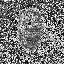

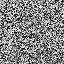

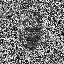

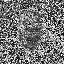

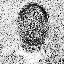

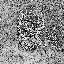

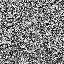

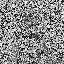

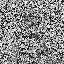

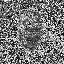

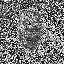

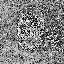

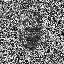

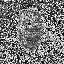

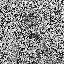

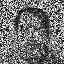

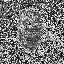

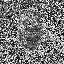

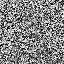

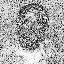

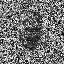

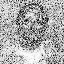

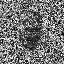

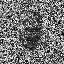

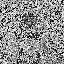

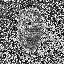

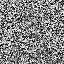

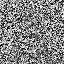

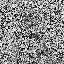

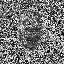

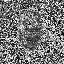

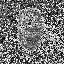

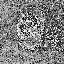

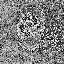

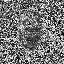

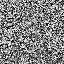

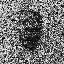

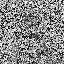

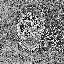

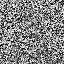

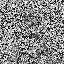

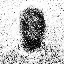

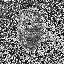

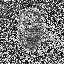

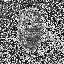

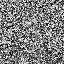

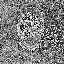

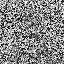

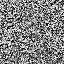

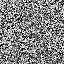

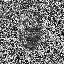

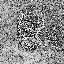

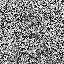

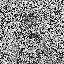

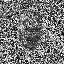

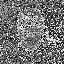

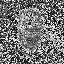

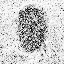

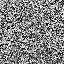

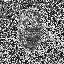

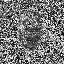

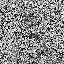

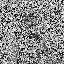

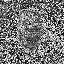

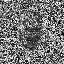

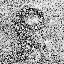

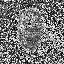

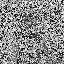

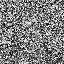

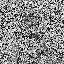

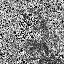

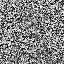

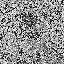

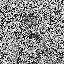

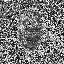

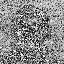

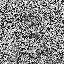

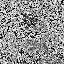

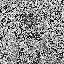

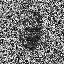

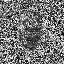

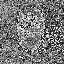

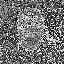

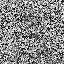

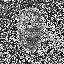

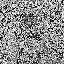

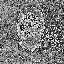

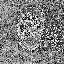

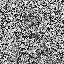

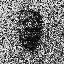

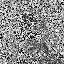

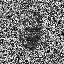

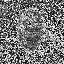

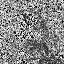

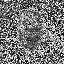

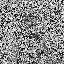

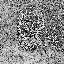

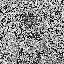

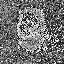

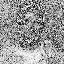

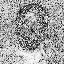

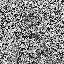

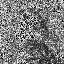

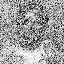

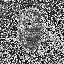

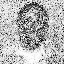

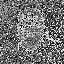

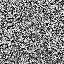

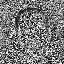

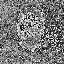

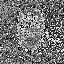

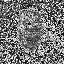

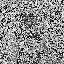

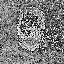

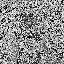

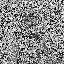

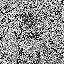

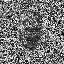

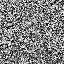

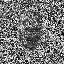

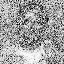

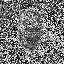

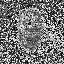

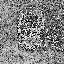

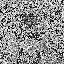

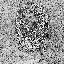

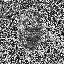

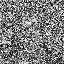

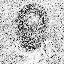

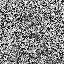

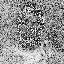

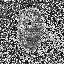

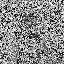

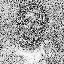

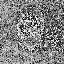

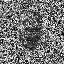

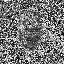

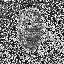

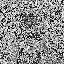

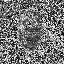

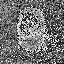

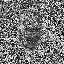

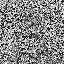

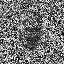

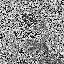

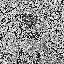

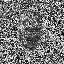

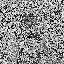

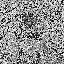

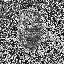

In [19]:
samples_to_try = torch.randn(samples_amount, generator_entry).to(device=device)
generated_samples = generator(samples_to_try).cpu().detach()

for i in range(samples_amount):
    image = transforms.ToPILImage()(generated_samples[i].reshape(image_size, image_size))
    display.display(image)